# Ensemble Kalman Filter Workflow

1. Available observation vector for $\vec{y_{k+1}}$, and calculate the observation ensemble from the directional uncertainties based on the wind speed and direction. To calculate the uncertainty for each point of the perimeter:
    1. Obtain the centroid $c_k = 1/M\sum{y_k}$ where $M$ is the number of points.
    2. Calculate vectors $\vec{v_k^m}$ for each point from the centroid to the point where $m$ is the $m^{th}$ point in the perimeter
    3. Obtain the wind speed and direction: $\vec{u_k}$ from the closest weather station to the centroid
    4. Uncertainty for each point $m$ is then $e_k^m = \alpha \left(1 - \vec{v_k^m} \cdot \vec{u_k}\right)$

2. Given a state vector $x_k$ and uncertainties around each point $P_k$, generate an ensemble 
$$X_k = (x_k^1, x_k^2, \cdots , x_k^N)$$
    1. For the first timepoint $k=0$, the state vector is the first observation $(x_0 = y_0)$, and the ensemble is obtained from directional uncertainties assigned based on the wind speed and direction
    2. **Question:** When creating the ensemble, do we preserve the mean $\overline{x_k}$?
    
3. From the ensemble $X_k$, advance for each state vector $X_{k+1} = F(X_k, u_k)$, where $u_k$ 

4. 

## Dependencies:

In [1]:
import sys
sys.path.append('/home/jovyan/farsite-devAPI/src/')
sys.path.append('/home/jovyan/python-helper/src/')

import geopandas as gpd
import pandas as pd
import numpy as np

from shapely.geometry import MultiPolygon, Polygon

import uuid
import random

import farsiteutils_v2 as futils
from kalmanutils import calculate_uncertainties_observed, interpolate_perimeter

from loggers import TimeEstimator

from matplotlib import pyplot as plt

## Default Values

In [2]:
SELECTED_FIRE_DEFAULT = 'Maria2019'
DATA_PATH = '/home/jovyan/data/'    # Folder to keep all the data while running the simulations

## Select a fire

```selected_fire``` variable holds the name of the fire selected. ```selected_fire = 'Maria2019'``` for now

In [3]:
fp = futils.FilePaths(DATA_PATH)
usr = futils.User(fp)

unique_desc = usr.db.gdfignitionAll['description'].unique()
print(f'Available fires are {unique_desc}')

selected_fire = SELECTED_FIRE_DEFAULT
print(f'{selected_fire} is selected.\n')
if (unique_desc == selected_fire).any():
    print(f'{selected_fire} is found!')
else:
    raise ValueError(f'{selected_fire} not found in possible fire descriptions: {unique_desc}')

Database interaction not yet implemented. Use pickle file for dataframes instead!
Available fires are ['Maria2019' 'River2021' 'Bridge2021']
Maria2019 is selected.

Maria2019 is found!


In [4]:
usr.db.gdfignition

,filetype,objectid,filepath,datetime,description,geometry
f23196b034474744bdca7df94b13e0f7,Ignition,21231,/home/jovyan/farsite/inputs/maria_ignite/maria...,2019-10-31 19:37:11,Maria2019,"POLYGON ((-2084217.148 1503560.461, -2084279.5..."
9f82e870591748a9a8a01346d174f2a1,Ignition,21232,/home/jovyan/farsite/inputs/maria_ignite/maria...,2019-10-31 19:58:22,Maria2019,"POLYGON ((-2082034.494 1504548.520, -2081987.6..."
1a6eb30ee33742e18fa6bb26678b5077,Ignition,21234,/home/jovyan/farsite/inputs/maria_ignite/maria...,2019-10-31 20:31:33,Maria2019,"POLYGON ((-2082034.494 1504548.520, -2081987.6..."
911f9b001c054b74a6ba70958f5f3c93,Ignition,21235,/home/jovyan/farsite/inputs/maria_ignite/maria...,2019-10-31 20:56:44,Maria2019,"POLYGON ((-2082396.219 1505343.939, -2082305.7..."
7957c2e604554199ba60c5b13aff2f40,Ignition,21236,/home/jovyan/farsite/inputs/maria_ignite/maria...,2019-10-31 21:22:55,Maria2019,"POLYGON ((-2082598.331 1505371.327, -2082338.5..."
714f0cf8d475462a97c651642a3d2525,Ignition,21237,/home/jovyan/farsite/inputs/maria_ignite/maria...,2019-10-31 23:31:00,Maria2019,"MULTIPOLYGON (((-2085055.250 1500983.797, -208..."
628d7730c0f149f898695d37a1350882,Ignition,21238,/home/jovyan/farsite/inputs/maria_ignite/maria...,2019-10-31 23:48:00,Maria2019,"POLYGON ((-2081520.701 1505276.095, -2081364.6..."
746e4f286cba4af4a89362b548f2c255,Ignition,21239,/home/jovyan/farsite/inputs/maria_ignite/maria...,2019-11-01 00:29:00,Maria2019,"POLYGON ((-2081508.646 1505341.661, -2081409.9..."
ec72de65d1934e0ab74ff46ffba1ae1b,Ignition,21240,/home/jovyan/farsite/inputs/maria_ignite/maria...,2019-11-01 00:54:00,Maria2019,"POLYGON ((-2081447.957 1505469.815, -2081376.9..."
15dc4b77768f4921be77c65ae9a6b9d4,Ignition,21241,/home/jovyan/farsite/inputs/maria_ignite/maria...,2019-11-01 01:12:00,Maria2019,"POLYGON ((-2081447.957 1505469.815, -2081376.9..."


In [5]:
referenceidx_lst = [usr.db.gdfignition.index[0]] + usr.db.gdfignition.index[-12:].tolist()

In [6]:
from shapely.geometry import MultiPolygon, Polygon
import numpy as np

def calculate_max_area_geom(multigeom):
    max_area = 0
    max_area_idx = 0
    for ix, g in enumerate(multigeom.geoms):
        if g.area > max_area:
            max_area = g.area
            max_area_idx = ix
    return multigeom.geoms[max_area_idx]
    

class State:
    def __init__(self, geom):
        self.geom = geom
        
        # Initialize
        self.vertices = self.calculate_vertices()
        self.lengths = self.calculate_lengths()
    def calculate_vertices(self):
        geom = self.geom
        
        if isinstance(geom, MultiPolygon):
            geompoly = calculate_max_area_geom(geom)
        elif isinstance(geom, Polygon):
            geompoly = geom

        return np.array((geompoly.exterior.coords))
    
    def calculate_lengths(self):
        return np.sqrt((np.diff(self.vertices, axis=0)**2).sum(axis=1))
    
    def calculate_vector(self):
        # Returns column vector of the vertices (x0, y0, x1, y1, ...)
        return self.vertices.reshape(len(self.vertices)*2, 1)
    
    

In [7]:
def sample_geometry(current_state, uncertainties):
    
    maxlength = current_state.lengths.max()
    
    sampled_vertices = []
    
    # Choose a random direction
    theta = random.uniform(0,2*np.pi)

    for (x,y), sigma in zip(current_state.vertices, uncertainties):
        mu=0
        # randx = random.gauss(mu, sigma)
        # randy = random.gauss(mu, sigma)
        
        # Choose a normal random radius based on the given sigma
        radius = abs(random.gauss(mu, sigma))
        
        # Calculate x and y distance for the random
        randx = radius*np.cos(theta)
        randy = radius*np.sin(theta)
        
        sampled_vertices.append((x+randx, y+randy))

    sampled_vertices = np.array(sampled_vertices)
    # return Polygon(sampled_vertices).buffer(maxlength, join_style=1).buffer(-maxlength, join_style=1)
    return Polygon(sampled_vertices)


def interpolate_geometries(geoms, vertex_count = None):
    
    if vertex_count == None:
        vertex_count = 0
        for geom in geoms:
            if isinstance(geom, MultiPolygon):
                geom = calculate_max_area_geom(geom)

            if vertex_count < len(geom.exterior.coords):
                vertex_count = len(geom.exterior.coords)

    interpolated_vertices = []
    for geom in geoms:
        if isinstance(geom, MultiPolygon):
            geom = calculate_max_area_geom(geom)
        
        geom_state = State(geom)
        vertices = np.array(interpolate_perimeter(geom_state.calculate_vertices(), vertex_count))

        interpolated_vertices.append(vertices)
        
    return interpolated_vertices


def align_vertices(interpolated_vertices):

    time_estimator = TimeEstimator(len(interpolated_vertices)-1)

    minroll_lst = []
    
    aligned_vertices = [interpolated_vertices[0]]
    for i in range(len(interpolated_vertices)-1):
        print(time_estimator.info_str(i), end='\r', flush=True)

        right_vertices = interpolated_vertices[i+1]


        # Cycle right_vertices
        l2perroll = []
        for roll in range(len(interpolated_vertices[i])-1):
            diff = aligned_vertices[0] - right_vertices
            diff2sum = (diff[:,0]**2 + diff[:,1]**2).sum()

            # Calculate diff^2 in
            l2perroll.append(diff2sum)

            right_vertices = np.roll(right_vertices,1, axis=0)

        minroll_lst.append(np.argmin(l2perroll))

    for i in range(len(interpolated_vertices)-1):
        aligned_vertices.append(np.roll(interpolated_vertices[i+1], minroll_lst[i], axis=0))
    
    return aligned_vertices
## Check reverse direction too?

def create_ensembles(nsamples, current_state, windspeed, winddirection, normalized_scale, filetype, objectid, datetime, description):
                     
    # uncertainty in both x and y for each vertex
    # uncertainties = calculate_uncertainties_observed(current_state.vertices, windspeed, winddirection, scale=windspeed*normalized_scale)*np.sqrt(current_state.lengths.sum())
    uncertainties = calculate_uncertainties_observed(current_state.vertices, windspeed, winddirection, scale=1)

    ignitions = {'igniteidx': [], 
                 'filetype': [],
                 'objectid': [],
                 'filepath': [],
                 'datetime': [],
                 'description': [],
                 'geometry': []}

    time_estimator = TimeEstimator(nsamples)
    for sample in range(nsamples):
        print(time_estimator.info_str(sample), end='\r', flush=True)
        
        igniteidx = uuid.uuid4().hex
        ignitions['igniteidx'].append(igniteidx)
        ignitions['filetype'].append(filetype)
        ignitions['objectid'].append(f'{objectid}E{sample:04d}')

        geometry = sample_geometry(current_state, uncertainties)
        if isinstance(geometry, MultiPolygon):
            geometry = calculate_max_area_geom(geometry)

        ignitions['geometry'].append(geometry)

        ignitions['filepath'].append(f'{usr.db.fp.datadir}ignitions/{selected_fire}E{igniteidx}.shp')
        gpd.GeoDataFrame({'FID': [0], 'geometry': ignitions['geometry'][-1]}, 
                         crs='EPSG:5070').to_file(ignitions['filepath'][-1])

        ignitions['datetime'].append(datetime)
        ignitions['description'].append(description)
        
    return ignitions


def create_ensemble_matrix(geoms, vertex_count=100, aligned_geom=None):

    interpolated_vertices = interpolate_geometries(geoms, vertex_count=vertex_count)
    # Add first list of vertices from the state vector to align. align_vertices aligns all the perimeters w.r.t the first array
    if aligned_geom is not None:
        interpolated_vertices = [aligned_geom] + interpolated_vertices

    aligned_vertices = align_vertices(interpolated_vertices)
    if aligned_geom is not None:
        aligned_vertices = aligned_vertices[1:]
    else:
        aligned_geom = aligned_vertices[0]
    
    if vertex_count is None:
        vertex_count = aligned_vertices[0].shape[0]
    
    X = np.zeros((vertex_count*2, nsamples))
    for i, vertices in enumerate(aligned_vertices):
        X[:,i] = vertices.flatten()
        
    return X, aligned_geom, vertex_count


def state_to_ignitions(X_0, objectid_lst, datetime_lst, description_lst, filetype_lst, usr):

    geoms = [Polygon(zip(X_0[::2,i], X_0[1::2,i])).buffer(0) for i in range(X_0.shape[1])]

    ignitions = {'igniteidx': [],
                 'filetype': [],
                 'objectid': [],
                 'filepath': [],
                 'geometry': [],
                 'datetime': [],
                 'description': []}

    for sample, geometry in enumerate(geoms):
        filetype = filetype_lst[sample]
        datetime = datetime_lst[sample]
        description = description_lst[sample]
        objectid = objectid_lst[sample]
        
        igniteidx = uuid.uuid4().hex
        ignitions['igniteidx'].append(igniteidx)
        ignitions['filetype'].append(filetype)
        ignitions['objectid'].append(f'{objectid}U{sample:04d}')

        if isinstance(geometry, MultiPolygon):
            geometry = calculate_max_area_geom(geometry)

        ignitions['geometry'].append(geometry)

        ignitions['filepath'].append(f'{usr.db.fp.datadir}ignitions/{description}U{sample:04d}_{igniteidx}.shp')
        gpd.GeoDataFrame({'FID': [0], 'geometry': ignitions['geometry'][-1]}, 
                         crs='EPSG:5070').to_file(ignitions['filepath'][-1])

        ignitions['datetime'].append(datetime)
        ignitions['description'].append(description)
    
    return ignitions

def validate_geoms_matrix(X, aligned_geom):
    for i in range(X.shape[1]):
        X_0 = X[:,i]
        x = X_0[::2]
        y = X_0[1::2]

        geom = Polygon(zip(x,y)).buffer(0)
        if isinstance(geom, MultiPolygon):
            geom = calculate_max_area_geom(geom)

        xx,yy = geom.exterior.xy
        xx = list(xx)
        yy = list(yy)

        geom = np.array(interpolate_perimeter(list(zip(xx, yy)), len(x)))
        geom = align_vertices([aligned_geom, geom])[1]

        X[:,i] = geom.flatten()

    return X

### Plotting functions

In [8]:
def compare_perimeters(alst, colors='rgbcmyk', showvertex = 0):
    fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)
    
    for a,c in zip(alst, colors):
        if c == 'r':
            ax.plot(a[::2], a[1::2], c+'o', markersize=1)
        else:
            ax.plot(a[::2], a[1::2], c)
            
        ax.scatter(a[2*showvertex], a[2*showvertex + 1], facecolor=(0,0,0,0.2), edgecolor=(0,0,0,0.9))
        
    ax.set_ylim(1.502e6, 1.506e6)
    ax.set_xlim(-2.087e6, -2.081e6)
    
def compare_matrices(X, colors='rgbcmy', showvertex = 0, ax=None):
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)
    
    for i in range(X.shape[1]):
        c = colors[i%len(colors)]
        ax.plot(X[::2,i], X[1::2,i], c)
        ax.scatter(X[2*showvertex,i], X[2*showvertex+1,i], facecolor=(0,0,0,0.2), edgecolor=(0,0,0,0.9))
        
    # ax.set_ylim(1.502e6, 1.506e6)
    # ax.set_xlim(-2.087e6, -2.081e6)
    
    return ax

def plot_geometry(geom, ax, **kwargs):
    if isinstance(geom, MultiPolygon):
        for g in geom.geoms:
            x,y = g.exterior.coords.xy
            ax.plot(x,y, **kwargs)
    else:
        x,y = geom.exterior.coords.xy
        ax.plot(x,y, **kwargs)
        
def plot_matrix(X, ax, show_stdev = False, **kwargs):
    vcounts = X.shape[0]//2
    
    color = (1,0,0,0.9)
    if 'color' in kwargs:
        color = kwargs['color']
        
    X_std = np.std(X, axis=1)
    X_mean = np.mean(X, axis=1)

    # Calculate standard deviation of the generated coordinates
    x0, y0 = X_mean[::2], X_mean[1::2]
    radstd = np.zeros_like(x0)
    
    for vix in range(vcounts):
        x,y = X[2*vix,:], X[2*vix+1,:]
        radius = np.sqrt((x-x0[vix])**2 +(y-y0[vix])**2)
        radstd[vix] = np.std(radius)
    
    ax.plot(X_mean[::2], X_mean[1::2], color=color)
    
    if show_stdev:
        for vix in range(vcounts):
            circle = plt.Circle((x0[vix], y0[vix]), radius=radstd[vix], fill=False, edgecolor=(0,0,0,0.4), lw=0.3)
            ax.add_artist(circle)

In [9]:
class EnKF:
    # Initialize with the first observation
    # Windspeed and direction is given from PyLaski
    def __init__(self, observation: gpd.GeoSeries, windspeed: int, winddirection: int, normalized_scale: float, nsamples: int, usr: futils.User):
        state_geom = gpd.read_file(observation['filepath'])['geometry'].set_crs(epsg=5070).iloc[0]
        
        
        self.state_datetime = observation['datetime']
        self.selected_fire = observation['description']
        self.igniteidx = observation.name
        self.current_state = State(state_geom)
        
        
        self.windspeed = windspeed
        self.winddirection = winddirection
        self.normalized_scale = normalized_scale
        self.nsamples = nsamples
        self.usr = usr

        self.ignitions = create_ensembles(self.nsamples, self.current_state, self.windspeed, self.winddirection, self.normalized_scale,
                                     observation['filetype'], observation['objectid'],
                                     observation['datetime'], observation['description'])
        
        self.usr.db.gdfignition = self.usr.db.gdfignition.append(gpd.GeoDataFrame(self.ignitions).set_index('igniteidx').set_crs(epsg=5070))
        
        # Create ensemble matrix
        self.X_0, self.aligned_geom, self.vertex_count = create_ensemble_matrix(self.ignitions['geometry'])
        
    # Updates the state matrix
    # Need to first add the observation into the database (usr.db for now)
    def update(self, compareidx: str, lcpidx: str, barrieridx: str, observation: gpd.GeoSeries, windspeed: int, winddirection: int):
        # Advance the state in Farsite using the windspeed and direction
        inputData_lst = []
        mainapi_lst = []
        for igniteidx in self.ignitions['igniteidx']:
            inputData = {'description': self.selected_fire,
                         'igniteidx'  : igniteidx,
                         'compareidx' : compareidx,
                         'lcpidx'     : lcpidx,
                         'barrieridx' : barrieridx,

                         'windspeed': windspeed, 'winddirection': winddirection,
                         'relhumid': 90, 'temperature': 20}

            mainapi_lst.append(self.usr.calculatePerimeters(inputData))
            

        # from multiprocessing import Pool

        # numproc = 4
        # pool = Pool(processes=numproc)

        # Run for each FarsiteManual
        for mainapi in mainapi_lst:
            # pool.apply_async(farsite.run_command, callback=farsite.updatedb)
            mainapi.run_farsite()

        # pool.close()
        # pool.join()
        
        # Filter igniteidx->compareidx simulations only
        df = self.usr.db.gdfsimulation
        filtered_indices = df[df['igniteidx'].isin(self.ignitions['igniteidx']) & (df['compareidx'] == compareidx)].index
        
        self.Xt_1, self.aligned_geom, self.vertex_count = create_ensemble_matrix(df.loc[filtered_indices, 'geometry'], 
                                                                                 self.vertex_count, self.aligned_geom)
        
        
        
        # Calculate ensemble for the observation
        state_geom = gpd.read_file(observation['filepath'])['geometry'].set_crs(epsg=5070).iloc[0]
        # igniteidx = observation.name
        state_datetime = observation['datetime']

        self.observed_state = State(state_geom)

        self.observed_ensemble = create_ensembles(self.nsamples, self.observed_state, windspeed, winddirection, self.normalized_scale,
                                     observation['filetype'], observation['objectid'],
                                     observation['datetime'], observation['description'])

        self.Y_1, self.aligned_geom, self.vertex_count = create_ensemble_matrix(self.observed_ensemble['geometry'], self.vertex_count, self.aligned_geom)
        
        ##############################
        # Calculate the Kalman Filter
        ###############################
        self.Xt_1 = remove_duplicates(self.Xt_1, self.vertex_count)
        self.Y_1 = remove_duplicates(self.Y_1, self.vertex_count)

        xt_1 = self.Xt_1.mean(axis=1, keepdims=True)
        y_1 = self.Y_1.mean(axis=1, keepdims=True)

        Ex_1 = self.Xt_1 - xt_1.repeat(self.nsamples, axis=1)
        Ey_1 = self.Y_1 - y_1.repeat(self.nsamples, axis=1)

        Py_1 = 1/(nsamples-1)*np.matmul(Ey_1, Ey_1.T)
        Pxy_1 = 1/(nsamples-1)*np.matmul(Ex_1, Ey_1.T)

        max_Py = abs(Py_1).max()
        max_Pxy = abs(Pxy_1).max()

        Py_1 /= max_Py
        Pxy_1 /= max_Pxy

        Py_1inv = np.linalg.pinv(Py_1, hermitian=True)
            
        assert(np.allclose(np.matmul(Py_1inv, Py_1), np.eye(2*self.vertex_count))), 'Inverse calculation is incorrect'

        self.K = np.matmul(Pxy_1, Py_1inv)*(max_Pxy/max_Py)

        #### Update the state ensemble
        self.X_1 = self.Xt_1 + np.matmul(self.K, (self.Y_1 - self.Xt_1))
        
        ### TODO ####
        # Fix invalid geometries
        
        self.X_1 = validate_geoms_matrix(self.X_1, self.aligned_geom)
        #############
        
        ####################
        # Recursive updates
        ##################
        
        # Update ignitions
        self.X_0 = self.X_1
        self.ignitions = state_to_ignitions(self.X_0, self.observed_ensemble['objectid'], self.observed_ensemble['datetime'], 
                           self.observed_ensemble['description'], self.observed_ensemble['filetype'], self.usr)
        
        self.current_state = self.observed_state
        
        self.usr.db.gdfignition = pd.concat([self.usr.db.gdfignition, gpd.GeoDataFrame(self.ignitions, geometry='geometry', crs='EPSG:5070').set_index('igniteidx')])
        
        # x_1 = X_1.mean(axis=1, keepdims=True)
        
# ## obtain the igniteidx of the ignition
# ## The indices will be passed from the interface, which will include corresponding datetime, filepath etc.
# compareidx = '9f82e870591748a9a8a01346d174f2a1'    # t=1 observation
# lcpidx = '43b7f5db36994599861eec4849cc68fd'        # Index for Maria2019
# barrieridx = 'cb47616cd2dc4ccc8fd523bd3a5064bb'    # NoBarrier shapefile index        

In [10]:
def calculate_model(igniteidx_lst, compareidx, lcpidx, barrieridx, windspeed, winddirection, usr_model):
    inputData = {'description': 'Maria2019',
                 'igniteidx'  : igniteidx_lst[-1],
                 'compareidx' : compareidx,
                 'lcpidx'     : lcpidx,
                 'barrieridx' : barrieridx,

                 'windspeed': windspeed, 'winddirection': winddirection,
                 'relhumid': 90, 'temperature': 20}

    mainapi = usr_model.calculatePerimeters(inputData)
    mainapi.run_farsite()

    gdfsim = usr_model.db.gdfsimulation.iloc[-1]
    gdfsim_geom = gdfsim['geometry']
    if isinstance(gdfsim_geom, MultiPolygon):
        gdfsim_geom = calculate_max_area_geom(gdfsim_geom)
    
    usr_model.db.gdfignition = pd.concat([usr_model.db.gdfignition, gpd.GeoDataFrame({'filetype': 'Ignition',
                                                                                      'objectid': str(usr_model.db.gdfignition.loc[gdfsim['igniteidx']]['objectid']) + '_farsite',
                                                                                      'filepath': gdfsim['filepath'],
                                                                                      'datetime': gdfsim['datetime'],
                                                                                      'description': gdfsim['description'],
                                                                                      'geometry': gdfsim_geom}, index=[gdfsim.name])
                                         ])
    igniteidx_lst.append(gdfsim.name)
    gpd.GeoDataFrame({'FID': [0], 'geometry':gdfsim_geom}, 
                     crs='EPSG:5070').to_file(gdfsim['filepath'])

In [11]:
def test_duplicates(arr):
    tst = []
    for rix in range(arr.shape[0]):
        for rjx in range(rix+1, arr.shape[0]):
            tst.append(arr[rix,:] - arr[rjx,:])

    tst = np.array(tst)
    tstsum = tst.sum(axis=1)
    zeroix = np.where(np.abs(tstsum) == 0)[0]

    i = 0
    rixlst = []
    rjxlst = []
    for rix in range(arr.shape[0]):
        for rjx in range(rix+1, arr.shape[0]):            
            if i in zeroix:
                print(f'{i} found at pair {rix}, {rjx}')
            i += 1

def remove_duplicates(arr, dnumber):
    tst = []
    for rix in range(arr.shape[0]):
        for rjx in range(rix+1, arr.shape[0]):
            tst.append(arr[rix,:] - arr[rjx,:])

    tst = np.array(tst)
    tstsum = tst.sum(axis=1)
    zeroix = np.where(np.abs(tstsum) == 0)[0]

    i = 0
    rixlst = []
    rjxlst = []
    for rix in range(arr.shape[0]):
        for rjx in range(rix+1, arr.shape[0]):            
            if i in zeroix:
                # print(f'{i} found at pair {rix}, {rjx}')
                rixlst.append(rix)
                rjxlst.append(rjx)
            i += 1

    arrnew = np.zeros_like(arr)
    arr = np.delete(arr, rixlst, axis=0)

    for j in range(arr.shape[1]):
        vertices = list(zip(arr[::2,j], arr[1::2,j]))
        vertices_interpolated = interpolate_perimeter(vertices, dnumber)

        arrnew[:,j] = np.array(vertices_interpolated).flatten()

    return arrnew

In [12]:
# Initial params

initial = usr.db.gdfignition.iloc[0]
windspeed = 10   # Calculations are made with windspeed = 10, winddirection = 90
winddirection = 60
nsamples = 250
normalized_scale = 2

state = EnKF(initial, windspeed, winddirection, normalized_scale, nsamples, usr)
X_0_lst = [state.X_0]

usr_model = futils.User(fp)
# igniteidx_lst = ['f23196b034474744bdca7df94b13e0f7']
igniteidx_lst = [referenceidx_lst[0]]

/tmp/ipykernel_14229/3636928067.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.usr.db.gdfignition = self.usr.db.gdfignition.append(gpd.GeoDataFrame(self.ignitions).set_index('igniteidx').set_crs(epsg=5070))


Database interaction not yet implemented. Use pickle file for dataframes instead!


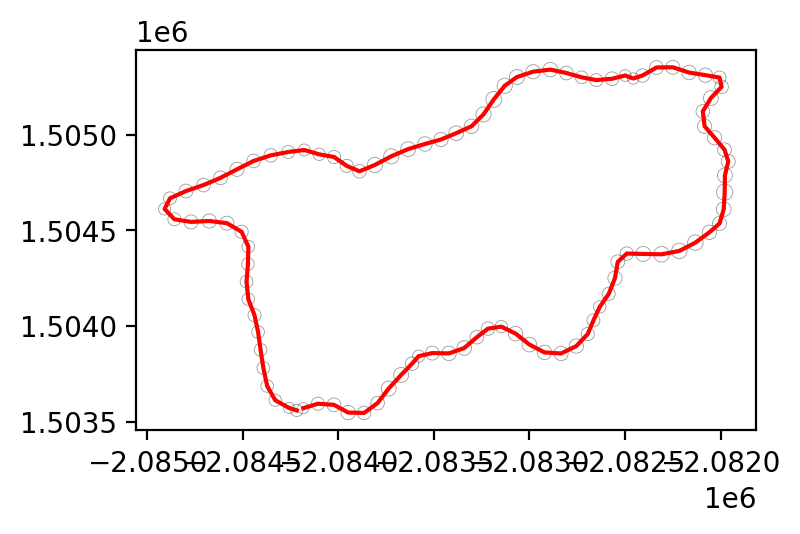

In [13]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
plot_matrix(X_0_lst[0], ax=ax, color='red', show_stdev=True)
ax.set_aspect('equal')

### Testing EnKF update function

In [ ]:
%%time

N = 100
sigma = 50

srange = np.arange(10,1001, 10)
detlst = []

time_estimator = TimeEstimator(len(srange))
for i, s in enumerate(srange):
    print(time_estimator.info_str(i), end='\r', flush=True)
    
    mat = np.random.randn(N,s)*50
    P_mat = np.matmul(mat, mat.T)/(nsamples-1)
    P_mat = P_mat/P_mat.max()
    
    detlst.append(np.linalg.det(P_mat))
# P_mat

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(3,2), dpi=200)
ax.plot(srange, detlst, 'k')
ax.set_ylim(0, 2e-6)

ax2 = ax.twinx()

ax2.semilogy(srange, detlst, 'r')
ax2.set_ylim(1e-50, 1e-5)
ax2.set_yticklabels(ax2.get_yticklabels(), color='red')

In [ ]:
# np.matmul(np.linalg.pinv(P_mat, hermitian=True), P_mat)

### Test EnKF is done

In [14]:
## obtain the igniteidx of the ignition
## The indices will be passed from the interface, which will include corresponding datetime, filepath etc.
lcpidx = '43b7f5db36994599861eec4849cc68fd'        # Index for Maria2019
barrieridx = 'cb47616cd2dc4ccc8fd523bd3a5064bb'    # NoBarrier shapefile index

# observation = usr.db.gdfignition.iloc[1]
observation = usr.db.gdfignition.loc[referenceidx_lst[1]]
compareidx = observation.name    # t=1 observation

state.update(compareidx, lcpidx, barrieridx, observation, windspeed, winddirection)
X_0_lst.append(state.X_0)

calculate_model(igniteidx_lst, compareidx, lcpidx, barrieridx, windspeed, winddirection, usr_model)

{'description': 'Maria2019', 'igniteidx': '61f1af846b7b46a49fcded85489dd55a', 'compareidx': '51fdaebe31f44ad69272779a3f01182d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
{'description': 'Maria2019', 'igniteidx': 'cb5fb1b9f3d84979994b03bacf1d5a57', 'compareidx': '51fdaebe31f44ad69272779a3f01182d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
{'description': 'Maria2019', 'igniteidx': 'd7333d5b5e334a808fbe2bcc66d3f0da', 'compareidx': '51fdaebe31f44ad69272779a3f01182d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the d

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00753/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ecb5fb1b9f3d84979994b03bacf1d5a57.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00753/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00754/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed7333d5b5e334a808fbe2bcc66d3f0da.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00755/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E8c3e193bd06d4cde97b05d4a1186cd2a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00755/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00756/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0b49a261207a491492638bf209c88bfb.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00756/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00757/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E2b4194355e3d4bfe87268b26966ba101.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00757/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00758/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E9950a92c479a44f4b2ccfe4799f8e21f.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00759/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E5fc21c7a664a45f4b1b7f134dfcdce60.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00759/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00760/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ebe6a9ff4ba91445491345c20ddadacb0.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00760/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00761/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E1973e05773674caca4a08f61213fda38.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00761/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00762/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E1a0aaadb887245dc8140a98744b5bffb.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00763/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E71618de3ca3b48268de42a0e9492afb0.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00763/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00764/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Efbd476c947294ac3b294afa9f8957b53.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00765/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E6582115a0f61451186c3d8e5545ec08d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00765/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00766/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E3d4723d44bae4228b8c9eef324ff373c.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00767/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E9d15b3e4cc6448b4b7b74db7af5ae5ca.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00767/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00768/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E3100df7023244967830e3951467b6a7e.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00769/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E3783f38b2a894883a5cd6756c7d20f15.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00769/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00770/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E2a98108ba84e4f749cef9ffc56703ebd.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00771/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E71640ace22b44483814a7213ec28cf31.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00771/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00772/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E4b5b52d7823e4a34ae1131e3c91d3960.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00772/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00773/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed32ef62a953a4991a6a73d1a374d652b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00773/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00774/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E4458ae0282a64a1394d161a8b5240a23.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00774/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00775/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ec3316bbd93e04c708b0d448fe3be6a95.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00776/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E75e0ca6dbc8345dbb29de4f227434e5f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00776/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00777/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E7920068afa0340949533163c09228352.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00778/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E1e7faac3d578497ebe8a861669e82f81.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00778/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00779/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0c767286b11c411aafbe2944ed338460.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00779/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00780/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eaf4854b431704a88b5ba078c9f05c8e9.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00780/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00781/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0f7a494ddd2f41f58189253ddce7f9a3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00781/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00782/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ef05980fc400947ce8850246e11f1a882.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00782/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00783/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E58f453e7416d475c86b48b973b1f6f1a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00783/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00784/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E8d1455a505ae4b91bc0313097c112c69.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00786/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E70cc89aee4cc4cedba851a2e2fcdf7ba.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00786/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00787/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E2ccb605bc9d04c918ec601faa960b79c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00787/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00788/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E865bdbef50314a708f465fa0113e70a6.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00789/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ebcbc6b3e8d6d46689bbccdb259d912c1.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00789/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00790/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E29918e3fa3134f1bb78c5e6b146daf89.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00791/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E217c7bf8ef304f8582de82c045f2d848.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00791/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00792/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E61d43fb456474f59b52e08617dffbe12.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00793/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ef8d4dd6d702843e88bf328a369eb8631.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00793/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00794/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E07b212baf58f4a5f90e3e9bf234824d5.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00794/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00795/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E537a672c65784af8bc0d24f7590dc446.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00795/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00796/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ef7153c55b92441e8a7d8af6f90c66d67.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00797/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed8ff9fc6165645ad835b20353a6d3a95.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00797/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00798/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E8f114090d1224916a946e118989a4eb2.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00799/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E5b660f51c1e0486997c34ba5a171efab.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00799/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00800/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E2982e15874774a78b46548731dfc208e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00800/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00801/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E39aba7d47c1947df8f7536544b57fee7.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00802/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ea9777685c9754d0ebd19080a8cf85298.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00802/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00803/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E9b00a30c3406497ca0f1ce077e548551.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00803/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00804/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E01e9447d61b24f44baa6aac5eadbfe18.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00806/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0922c06e5d34412cb7a83316f3e5a0fd.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00806/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00807/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E52936e79b8bc4ae99cb9abcc01bda194.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00807/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00808/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ec1471401a232408282318306b0fce118.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00808/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00809/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed4af94bba5aa430a88cc77cef195cd69.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00809/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00810/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0fb7f04c6bce45c4be9935f98bc0e3dc.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00810/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00811/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E8107d405cd4d4134b05abdee9883327b.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00812/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E28af6eb89b054feb83498d8ccd918ac1.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00812/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00813/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eb22a9a459d344d478da15d368c91928b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00813/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00814/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ea9e78f7debf1424093f4ae16a7437cff.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00814/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00815/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E2582cd7e2ea24f85aafb53c0e1375278.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00815/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00816/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ea4174d02ea6f45449774c5a442e62fda.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00816/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00817/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E5384696bb92845f9a35afe4ef3c7ad40.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00817/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00818/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0cdc19d5969346c6ad6eb42045353fc3.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00819/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E1e3ef4a1468940fbb7252a2171e79442.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00819/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00820/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E87e9330d0e2a43398625a160b2f355e4.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00820/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00821/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E33f07d43c1364c4788e4c1457d7dcf50.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00821/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00822/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E4054b3d97e404a43830c68b66469e8c0.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00822/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00823/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0a27c4052b454ba3bd10c110d20a71d1.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00823/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00824/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eb17b68fadda641228aa87d19a4c0349a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00824/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00825/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eac56580cb3e241298e06ec923be6f443.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00826/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E4e3fc07addde4d54a89d020e6693b623.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00826/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00827/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0f9aca44ddab4c599ef91eae15178099.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00827/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00828/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E3524795d47354fb78ab1056a0c984cba.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00828/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00829/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E3105dcac5d95414d9d27fc7b36dcbe31.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00829/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00830/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E375b1ea9e169497584b53f2e9885e483.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00830/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00831/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ea7b26dee9c5c4507a16c7ed365ead0b3.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00832/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E3b6dbdb57d784234a1869d2a0ba62cd3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00832/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00833/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E2b4df310198042c08a7a19bb081001b2.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00833/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00834/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ea53a67683b8f479c89a0a67c1e2ea720.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00834/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00835/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ee30320ce25c84908a814e92f94e4d4f3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00835/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00836/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E268a41c5be314ea9ae8134886d253cbd.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00836/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00837/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ea01b325762dc41359d9d6bfed3a1644b.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00838/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed61d139255024d17b9db7019a9295fd9.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00838/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00839/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E87c3853cba6d434cbc34eb4ef175e74b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00839/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00840/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E538e7bf0cad54bc493b0778af66032af.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00841/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E141aae3276c34b5aabb34532a4a3fe70.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00841/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00842/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eb8e345ca935c4e8dadf8502111bd24ad.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00842/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00843/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E6b515e52bf63408a8c05681b0ab2de90.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00843/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00844/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E7435af37343043b0a3ac6126a8db9c4b.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00845/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E29384ebfb7b746af86f1ac4b3f3df784.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00845/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00846/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ec1772621aea64631acd0d8b3c10d128f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00846/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00847/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E37eface554ea46429ffe0af5717b9c3a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00847/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00848/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E24440470fca14c47abe7e0da3e0ec7f6.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00848/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00849/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ee763e8fb47434cd58df8cfe408879188.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00849/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00850/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ee900da451ecd42288ea8a281de32d693.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00850/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00851/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E791bf7a1f94a4093805aae4d084beb5d.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00852/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ec77c3359be4d44989bf9a8ce90a2985c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00852/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00853/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eb1ef282012764c3ea2c31962ead241ae.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00853/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00854/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E525459f9a6b745ca825f2c8e7c7b9f0a.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00855/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E615ff4a1ed1f4dfdbae28feb0d5a5b89.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00855/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00856/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E29bfb4bf632e46bdbba168a48beb4095.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00856/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00857/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E22b8e2af83c44e1ab46455b7a7f107bd.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00857/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00858/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed08e8136ef17468990343a1f36e9f4f4.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00859/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ec731f4c017ce48af8f4865d345008019.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00859/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00860/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ee9cd97a7dca0461d9590f053144ed2c4.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00860/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00861/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0b1cb497739d47ca8bcf347c01230e36.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00862/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ea96239f4f07b45708f3ae89c4621eb8f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00862/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00863/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E76bc6cb344904c2e97144f15b62c4829.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00864/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ebcc7341195bc4f8f9f612bd5a6142c66.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00864/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00865/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed022094edcb94b04830ac78564c52917.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00865/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00866/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E5165212dc38b43cbbf424969052d8b92.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00866/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00867/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Efc3f2b8389a94c30aa86a9f40b1d9f97.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00867/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00868/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ee1ec0c36bdfa44bdaff05c14f42ec2b4.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00868/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00869/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eb8437bb81120438cb9fb24a3a16f157b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00869/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00870/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eeb2565daf3e545668c086c66989d73a1.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00872/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E5e787c0d840b4d85bfdb0a19b2208d63.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00872/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00873/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E00745b81dc77442a995b0e87c693300a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00873/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00874/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E5270b6fef39b49508b787cbda4e3d065.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00874/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00875/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E6c1171531f8047a899adc8867eb7e312.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00875/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00876/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E62963fbca06b42bfaf9704a53435382c.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00877/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ea384c4dcdee14530afdb1bceddd2a7bf.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00877/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00878/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ebc7a5988a2004de09dd0e52dc9c876b5.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00878/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00879/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Edaa304b61c944b3db0e29572a9813f7b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00879/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00880/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E374974cc321648ad9b0c64607a25abe6.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00880/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00881/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ef7c2491c2e7149e287383134f0503237.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00883/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E155b448a7dd547eda860c9b9453c9428.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00883/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00884/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E7c6761200fea40beaaa1a54349485a54.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00884/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00885/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eaebfa47e659b4c2e8e7072ba4030ac4c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00885/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00886/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E7e61d30c9cb54d4082074b8657fd8260.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00887/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ebd2f8ec494d843758a6b03b2f2ca2401.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00887/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00888/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eea0f1ed6e9a947a6bc7140b9af8ab871.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00888/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00889/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Edafc383052dd4ca4af18f42f16fa0690.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00889/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00890/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E24359ba71f334cd9962e2d71d2647c97.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00890/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00891/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eceb1fbfdc63e4d089fbcbe58d57bd7c0.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00891/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00892/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E1411c90d20c14096a999cef95f764d69.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00892/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00893/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E2b9a469215414598a372436dea066a9a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00893/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00894/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed74c135100dc45a7aed1f93acd0b023f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00894/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00895/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E3b62ed0f52fd4b6aa932c068d53e900c.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00896/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E7e1adaa86dab4eb7b83652a7762a5633.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00896/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00897/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E5d26a9c9f4fe43fd9bf2ce500d4e8722.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00898/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E43a658e05acb441581b4725794d91292.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00898/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00899/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E64b8d9ab49ad4fce8ef2bb5f1b937437.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00899/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00900/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E14efb09add0b467696aa1c20ea750d9d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00900/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00901/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eecf59e55e3544bfabb50b4e5f7af111b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00901/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00902/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E03181ff15ad1437f803a966118158dcd.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00902/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00903/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ec7873baa57b74b41aabf58cbd472294a.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00904/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E734412f844f447d9908d6eb89c4cb22f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00904/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00905/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E767255088b554e7e963ceea2b225e275.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00905/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00906/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ec39c837617f0468881c615b176b24eac.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00907/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eab62519e557445fdb50aa3b632e918d9.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00907/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00908/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E1626c51c88674417b78ba024bcf30dfc.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00909/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E31a603151e344f32b1f094db13c901a4.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00909/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00910/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed1a4b66fb996480896c610c3d4779eae.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00910/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00911/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E51a35a5bd1d54d3e9c7fa0d8c34cd2a3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00911/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00912/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E6cafbce7ee1442c3868a234774c294d3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00912/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00913/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E8ebbc0828b524098b532d84717a17741.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00913/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00914/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E67e0095cdae24243bd39fc74e3056d3e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00914/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00915/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E3a879cd16930459098723224d2ed45ea.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00915/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00916/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E759269dd7e424c389061ae191ffeb9e8.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00916/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00917/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ef23efcdf3bf4429e8690c2a932a5bf6f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00917/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00918/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ea55d6c6a330b4a6e9cb6e9707f31799c.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00919/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ee322f3268aa0422cbc0d700645cddbac.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00919/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00920/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E5f5aa6d4968647ab96a3cc0fff4315c4.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00920/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00921/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E9f86bc40bcf44e839631cb9a23190c9e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00921/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00922/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E5f03a16bf0a6460d9ac8f17bdc28429c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00922/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00923/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eb5e99e9cd6654b58b7fc338369242fbb.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00923/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00924/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E161e9ec5bb6d412db3baab3668af02d3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00924/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00925/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E63fc7548f8d0449cb25ecce19e360e80.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00925/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00926/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E35fd6150f35147d58a4796b92469bf6e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00926/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00927/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E751f20b3e3a04ee98597ca0b3e624a7f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00927/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00928/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ea117c8840685419ebc1946f1f30b0948.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00928/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00929/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed888f827e4f045c38f48fe12b260344b.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00930/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E2faf85090e90447bb13b90eaa325182f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00930/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00931/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E6d5acadba4914c12a9f9fb449efadc6f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00931/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00932/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E9e4438eaf73d44aa80bd66cea553dadf.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00933/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ebc81093baa454f12801d303084d38d97.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00933/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00934/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eda55c769b252418f8316078d8c72c23a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00934/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00935/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ee04a6907542b430d9dd59f108be32d18.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00935/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00936/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0d0dfc10248c45bd850ed1e2e64768af.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00937/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E7eb9872730af49a3bc1cce783e49908d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00937/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00938/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E625c9d7b516c4a30ab0bf3375755ab20.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00938/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00939/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E8dd0917e3cb541d6b4c1cf674bf9faef.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00940/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ef85a25214eff4f15844aef9764ee9a63.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00940/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00941/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E6386a5308c3a4867a6825e389a8b2df8.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00941/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00942/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E530d7b95bfd04f2e8186e2656102b735.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00942/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00943/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E6cf9fb6997e2458c836ee4084d95a3ce.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00943/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00944/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eeddc8be1c7f24e8a819f90421bd7b2bd.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00945/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ea7e72c69e3474de28ebffc78b57ef7bf.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00945/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00946/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E7d3095d848a245da813249723d7919b1.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00946/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00947/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E4dee233b14f741afa722d4974de42711.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00948/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E3ce1107dbf674c4388360ec181b1ae66.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00948/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00949/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E140c1e24a6cb41748ff85ef49b76f8d1.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00950/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed21df6f58a25415a8ffad609dda6bd6c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00950/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00951/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eb6f0f748bf104409a393e355a76e2bf8.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00951/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00952/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E8e2820a0017048d9a808f793f51ce6c1.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00952/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00953/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E6dc7ca6be32d49bfa765f60088c2f14c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00953/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00954/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ecc37f786679740dbb60d10ff3cad1d98.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00954/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00955/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ebe2922ffcce14018b25cb404f1bb29f5.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00955/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00956/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Efc71eeb896824fb089e8006b4474e28b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00956/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00957/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ecf044c52f8e3434ba00c2e1bc1c5d278.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00957/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00958/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Efe825040df334a16b2fd8fbf06da37f1.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00958/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00959/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E8ae9126bd08f4955b9f984ba0789ec53.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00959/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00960/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ee265386b9c204140bb9b6e10076591ce.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00960/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00961/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E908ab7787b1f4840b616610d627f41b4.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00961/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00962/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed0b5f4b4678b4be2aef8241e81067f8b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00962/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00963/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E52031d33c5a64128b5157e22f63d14af.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00963/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00964/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed88be74656324a50b5bd1c93820537c8.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00965/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0ed0176b4b6f43bab4515e065c6680f7.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00965/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00966/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E5e474aa4524a4856a6e6d4703f5248c2.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00966/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00967/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E66435d2d770941389d1a71d49246a37f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00967/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00968/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ef2a32cd7132f44449aa937a6ff0db177.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00968/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00969/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E40c12e6b00294aa5bcd4594d3a5abcf6.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00969/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00970/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E78df544a074f4ddebc30a28ff85323a4.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00970/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00971/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E25ab5e377258422a9ffc8662f924cc7a.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00972/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0546abaa12374a77bfeba156a89d4616.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00972/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00973/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E3df481eb2ef244cfa92478df13e049a5.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00973/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00974/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eb600814667254c4fa449566ef6445fdd.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00974/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00975/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E240821e4b97a4e339c01059f9bec0340.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00975/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00976/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E65923fe974304bbe9d1904405b204985.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00977/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ebffe6d9580444e1baa5de77bce532ecb.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00977/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00978/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E55ae4615e0e94e4f8a992182e831e114.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00978/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00979/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E286827b9429649218c9d7839a8685786.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00980/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0695cbe933ec4c10b12019138cd76887.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00980/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00981/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E19a5eebabf4c49b5a8735e5d1c5e6e4f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00981/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00982/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E7ac09529e64d40259ea1aef66813e1c4.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00983/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E5387ce23b8624f408844fa8b0e7dd1bb.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00983/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00984/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E5b64b26e61054c589f675b1271e0e563.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00984/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00985/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E7b83ab9746b444cba753b18c334509ed.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00985/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00986/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ef6e0dc31df754de69cfe7c1e852e478c.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00987/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E2dc00c21e8cc4fe38b4d0513ae392f58.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00987/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00988/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E6e33edca4b63471294f2912e10d47e4b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00988/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00989/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E6f092c9e4b9d4cdda9c6190905f8c6ce.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00990/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eab8d391fe29c4a2383caf6b1f775d214.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00990/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00991/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed23046c5796b4dc385755e502ba106b5.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00992/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E689c79feb8f4421a9e7dc24f439de6ca.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00992/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00993/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ec2318476f52e4ce78712aa4c9c8bc969.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00993/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00994/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E1eff6fe499ac4e1ab8fcad6c3b54f569.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00995/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E7c0578def77c46df84c25ec1d3e1db12.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00995/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00996/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed749856ab54242898e60d2f8fcb3a41b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00996/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00997/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ec54f2afda55d4238891475d646304a80.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00997/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00998/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E082fdc5c156f45e5934434a721cb0dce.shp
Loading barrier file for Farsite #1: /home/jovyan

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_00999/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E219bf3a703364551bf520926e07e47d4.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_00999/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_01000/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E59f75568641a456bb7a1bcd1e71890b4.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_01000/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_01001/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E8aa6498a4d564a6e903ef4358b289aab.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_01001/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


{'description': 'Maria2019', 'igniteidx': 'f23196b034474744bdca7df94b13e0f7', 'compareidx': '51fdaebe31f44ad69272779a3f01182d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230303/Run_01002/config
Loading ignition file for Farsite #1: /home/jovyan/farsite/inputs/maria_ignite/maria_21231.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230303/Run_01002/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


### Fixing the invalid geometries

In [ ]:
X_0 = X_0_lst[1][:,0]
x = X_0[::2]
y = X_0[1::2]
geom = Polygon(zip(x,y)).buffer(0)
if isinstance(geom, MultiPolygon):
    geom = calculate_max_area_geom(geom)
geom

In [ ]:
X_0_lst[1].shape[1]

In [ ]:

# i = 25
# plt.plot(geom0[:,0], geom0[:,1], 'r-')
# plt.plot(geom0[i,0], geom0[i,1], 'ro')
# plt.plot(geom1[:,0], geom1[:,1], 'k-')
# plt.plot(geom1[i,0], geom1[i,1], 'ko')

In [ ]:
interpolated_vertices = [geom0, geom1]

In [ ]:
time_estimator = TimeEstimator(len(interpolated_vertices)-1)

minroll_lst = []

aligned_vertices = [interpolated_vertices[0]]
for i in range(len(interpolated_vertices)-1):
    print(time_estimator.info_str(i), end='\r', flush=True)

    right_vertices = interpolated_vertices[i+1]


    # Cycle right_vertices
    l2perroll = []
    for roll in range(len(interpolated_vertices[i])-1):
        diff = aligned_vertices[0] - right_vertices
        diff2sum = (diff[:,0]**2 + diff[:,1]**2).sum()

        # Calculate diff^2 in
        l2perroll.append(diff2sum)

        right_vertices = np.roll(right_vertices,1, axis=0)

    minroll_lst.append(np.argmin(l2perroll))

for i in range(len(interpolated_vertices)-1):
    aligned_vertices.append(np.roll(interpolated_vertices[i+1], minroll_lst[i], axis=0))

# return aligned_vertices

In [ ]:
geom0, geom1 = aligned_vertices
i = 0
plt.plot(geom0[:,0], geom0[:,1], 'r-')
plt.plot(geom0[i,0], geom0[i,1], 'ro')
plt.plot(geom1[:,0], geom1[:,1], 'k-')
plt.plot(geom1[i,0], geom1[i,1], 'ko')

#### Fixing is done

In [15]:
X_0_lst[1].shape

(200, 250)

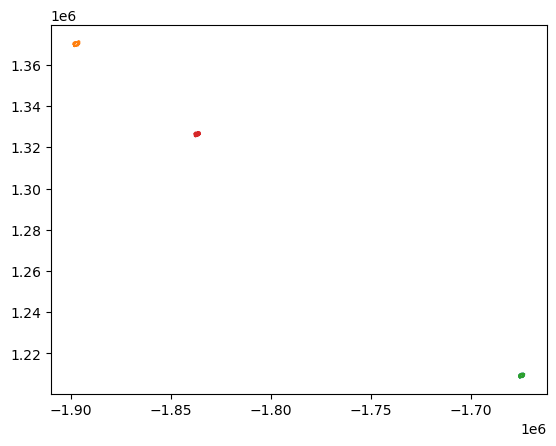

In [17]:
# fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
# plot_matrix(X_0_lst[0], ax=ax, color='red', show_stdev=True)
# ax.set_aspect('equal')

plt.plot(X_0_lst[1][::2, 50], X_0_lst[1][1::2, 50])
plt.plot(X_0_lst[1][::2, 1], X_0_lst[1][1::2, 1])
# plt.plot(X_0_lst[1][50, 0], X_0_lst[1][51, 0], 'ro')

plt.plot(X_0_lst[1][::2, 50], X_0_lst[1][1::2, 50])
plt.plot(X_0_lst[1][::2, 150], X_0_lst[1][1::2, 150])
# plt.plot(X_0_lst[1][50, 50], X_0_lst[1][51, 50], 'ko')

In [ ]:
# # fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
# # # plot_matrix(X_0_lst[0], ax=ax, color='red', ls='-')
# # plot_matrix(X_0_lst[1], ax=ax, show_stdev=True, color='blue', ls='--')
# # ax.set_aspect('equal')
# k = 1
# fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
# for i in [0,5,10,15,20,25,50]:
#     ax.plot(X_0_lst[k][::2, i], X_0_lst[k][1::2, i])

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
# plot_matrix(state.Xt_1, ax=ax, color='red', show_stdev=True)
# plot_matrix(X_0_lst[0], ax=ax, color='black', show_stdev=True)
# plot_matrix(state.Y_1, ax=ax, color='blue', show_stdev=True)
# plot_matrix(state.X_1, ax=ax, color='black', show_stdev=True)
plot_matrix(X_0_lst[1], ax=ax, color='black', show_stdev=True)


ax.set_aspect('equal')

In [ ]:
%%time

calc_range = range(2,10)
time_estimator = TimeEstimator(len(calc_range))
for i in calc_range:
    print(time_estimator.info_str(i))
    observation = usr.db.gdfignition.iloc[i]
    compareidx = observation.name    # t=1 observation

    state.update(compareidx, lcpidx, barrieridx, observation, windspeed, winddirection)
    X_0_lst.append(state.X_0)

    calculate_model(igniteidx_lst, compareidx, lcpidx, barrieridx, windspeed, winddirection, usr_model)
    
igniteidx_lst_model = igniteidx_lst.copy()

In [ ]:
# import geopandas as gpd

# gdf = gpd.read_file('/home/jovyan/data/ignitions/Maria2019U0081_f5421b23173641e18b5d780c6d528798.shp')
# gdf['geometry'][0]

In [ ]:
# fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)

# # plot_matrix(X_0_lst[0], ax)
# # plot_matrix(X_0_lst[1], ax, color='blue')
# plot_matrix(X_0_lst[0], ax, color='black')
# plot_matrix(X_0_lst[1], ax, color='black')
# plot_matrix(X_0_lst[2], ax, color='black')
# plot_matrix(X_0_lst[3], ax, color='black')
# plot_matrix(X_0_lst[4], ax, color='black')
# plot_matrix(X_0_lst[5], ax, color='black')
# plot_matrix(X_0_lst[6], ax, color='black')
# plot_geometry(usr.db.gdfignition.iloc[4]['geometry'], ax)
# plot_geometry(usr.db.gdfignition.iloc[5]['geometry'], ax)
# plot_geometry(usr.db.gdfignition.iloc[6]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[10]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[11]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[12]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[13]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[14]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[15]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[16]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[17]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[18]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[0]['geometry'], ax)

## Compare the predictions from the updated states, observations and using only the first simulation

### 1. Predict with the updated states

In [ ]:
usr_combined = futils.User(fp)
igniteidx_lst = []
compareidx_lst = []
for i, X_0 in enumerate(X_0_lst):
    obrow = usr.db.gdfignition.iloc[i]
    comprow = usr.db.gdfignition.iloc[i+1]
    
    vertices = X_0.mean(axis=1)
    geom = Polygon(zip(vertices[::2],vertices[1::2])).buffer(0)
    
    dt = obrow['datetime']
    desc = obrow['description']
    objid = str(obrow['objectid']) + '_updated'
    ftype = obrow['filetype']
    
    ignitions = state_to_ignitions(X_0.mean(axis=1, keepdims=True), [objid], [dt], [desc], [ftype], usr_combined)
    igniteidx_lst.append(ignitions['igniteidx'][0])
    compareidx_lst.append(comprow.name)
    
    usr_combined.db.gdfignition = pd.concat([usr_combined.db.gdfignition, gpd.GeoDataFrame(ignitions, geometry='geometry', crs='EPSG:5070').set_index('igniteidx')])

In [ ]:
igniteidx_lst_observed = []
compareidx_lst_observed = []
for i in range(len(igniteidx_lst)):
    igniteidx_lst_observed.append(usr_combined.db.gdfignition.index[i])
    compareidx_lst_observed.append(usr_combined.db.gdfignition.index[i+1])

In [ ]:
# Combine all igniteidx and compareidx into a single

igniteidx_lst_combined = igniteidx_lst + igniteidx_lst_observed
compareidx_lst_combined = compareidx_lst + compareidx_lst_observed

desc_lst_combined = ['Maria2019_updated' for i in range(len(igniteidx_lst))] + ['Maria2019_observed' for i in range(len(igniteidx_lst))]
inputData_lst = []
mainapi_lst = []
for (igniteidx, compareidx, desc) in zip(igniteidx_lst_combined, compareidx_lst_combined, desc_lst_combined):
    inputData = {'description': desc,
                 'igniteidx'  : igniteidx,
                 'compareidx' : compareidx,
                 'lcpidx'     : '43b7f5db36994599861eec4849cc68fd',
                 'barrieridx' : 'cb47616cd2dc4ccc8fd523bd3a5064bb',
                 
                 'windspeed': 10, 'winddirection': 60,
                 'relhumid': 90, 'temperature': 20}
    
    mainapi_lst.append(usr_combined.calculatePerimeters(inputData))
    
for mainapi in mainapi_lst:
    # pool.apply_async(farsite.run_command, callback=farsite.updatedb)
    mainapi.run_farsite()

In [ ]:
# usr_combined.db.gdfignition.to_pickle('/home/jovyan/ignitions.pkl')
# usr_combined.db.gdfsimulation.to_pickle('/home/jovyan/simulations.pkl')

#### Interpolate all the vertices

#### TODO: Vertices include an additional point when generated from geometry. Remove the repeat!

#### TODO: Check whether the aligned_vertices have the correct roll amount
1. Create matrices from the aligned_vertices, and form the $X_0$ ensemble state matrix
2. Using the observation $y_1$, update the state vector and obtain $X_1$

#### TODO - Question: Can we find a way to not interpolate the vertices
1. Without interpolation, we need to create a matrix that maps the observed vertices to the state vector

## Compare the perimeters

In [ ]:
# gdfignition = pd.read_pickle('/home/jovyan/ignitions.pkl')
# gdfsimulation = pd.read_pickle('/home/jovyan/simulations.pkl')

gdfignition = usr_combined.db.gdfignition
gdfsimulation = usr_combined.db.gdfsimulation

gdfignition_model = usr_model.db.gdfignition
gdfsimulation_model = usr_model.db.gdfsimulation

In [ ]:
def get_coordinates(geom):
    x,y = geom.exterior.coords.xy
    x = np.array(x)
    y = np.array(y)
    
    return x,y

def calculate_rms(geom1, geom2):
    xy1, xy2 = interpolate_geometries([geom1, geom2], vertex_count=2000)
    xy1, xy2 = align_vertices([xy1, xy2])
    return np.sqrt(np.sum((xy1[:,0] - xy2[:,0])**2 + (xy1[:,1] - xy2[:,1])**2)/xy1.shape[0])
    

def calculate_area_diff(geom1, geom2):
    return (geom1.union(geom2) - geom1.intersection(geom2)).area

calculate_error = calculate_area_diff

In [ ]:
geoms_updated = []
geoms_observed = []
geoms_compare = []
geoms_model = []
errors_updated = []
errors_observed = []
errors_model = []
dt = []

for compareidx in compareidx_lst[:-1]:
    gdffiltered = gdfsimulation[gdfsimulation['compareidx'] == compareidx]
    
    geom_updated = gdffiltered[gdffiltered['description'] == 'Maria2019_updated']['geometry'].iloc[0]
    if isinstance(geom_updated, MultiPolygon):
        geom_updated = calculate_max_area_geom(geom_updated)
    geoms_updated.append(geom_updated)
    
    geom_observed = gdffiltered[gdffiltered['description'] == 'Maria2019_observed']['geometry'].iloc[0]
    if isinstance(geom_observed, MultiPolygon):
        geom_observed = calculate_max_area_geom(geom_observed)
    geoms_observed.append(geom_observed)
    
    geom_compare = gdfignition.loc[compareidx, 'geometry']
    if isinstance(geom_compare, MultiPolygon):
        geom_compare = calculate_max_area_geom(geom_compare)
    geoms_compare.append(geom_compare)
    
    gdffiltered_model = gdfsimulation_model[gdfsimulation_model['compareidx'] == compareidx]
    geom_model = gdffiltered_model[gdffiltered_model['description'] == 'Maria2019']['geometry'].iloc[0]
    if isinstance(geom_model, MultiPolygon):
            geom_model = calculate_max_area_geom(geom_model)
    geoms_model.append(geom_model)
    
    dt.append((gdfignition.loc[compareidx, 'datetime'] - gdfignition.iloc[0]['datetime']).total_seconds()/60/60)
    
    errors_updated.append(calculate_error(geom_updated, geom_compare))
    errors_observed.append(calculate_error(geom_observed,  geom_compare))
    errors_model.append(calculate_error(geom_model, geom_compare))

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4,3), dpi=400)
ax.plot(dt, errors_updated, label='EnKF')
ax.plot(dt, errors_observed, label='Observed')
ax.plot(dt, errors_model, label='Model')

ax.set_xlim(0,6)
ax.set_ylim(0, 2.5e7)

ax.set_xlabel('Hours after first ignition')
ax.set_ylabel('Area difference')

ax.legend()